In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print('Shape of training images:', x_train.shape)
print('Shape of training labels:', y_train.shape)
print('Shape of testing images:', x_test.shape)
print('Shape of testing labels:', y_test.shape)

170498071/170498071 [==============================] - 5s 0us/step
Shape of training images: (50000, 32, 32, 3)
Shape of training labels: (50000, 1)
Shape of testing images: (10000, 32, 32, 3)
Shape of testing labels: (10000, 1)


In [4]:
# Class labels for CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

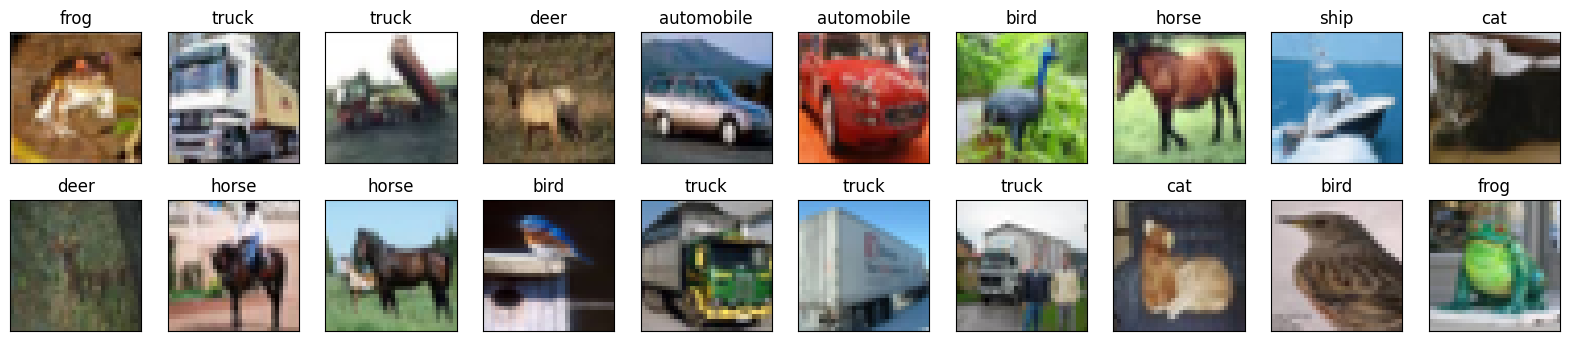

In [5]:
# Show some training sample images
fig = plt.figure(figsize=(20, 4))

for idx in range(20):
    ax = plt.subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(x_train[idx])
    plt.title(classes[int(y_train[idx])])

In [ ]:
# Load the DenseNet model with pre-trained weights, excluding the top layer
densenet = tf.keras.applications.densenet.DenseNet201(input_shape=(32, 32, 3), weights='imagenet', include_top=False)

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
# Add custom layers on top of the base model
x = layers.GlobalAveragePooling2D()(densenet.output)
x = layers.Dropout(0.2)(x)
x = layers.Dense(units=1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(units=10, activation='softmax')(x)

model = Model(inputs=densenet.input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 38, 38, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 16, 16, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1/conv[0][0]']      

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [ ]:
# Define the model path for saving
model_path = '/content/drive/MyDrive/Adversarial-Robustness-of-ViTs-vs-CNNs/trained_models/cifar10_densenet.h5'

# Set up callbacks for early stopping and model checkpoint
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             verbose=1,
                             save_best_only=True,
                             mode="auto",
                             save_weights_only=False)

early = EarlyStopping(monitor="val_loss",
                      mode="auto",
                      patience=5)

callbacks_list = [checkpoint, early]

In [ ]:
# Train the model
model.fit(x_train, y_train,
          batch_size=32,
          epochs=100,
          validation_data=(x_test, y_test),
          callbacks=callbacks_list)

Epoch 1/100
1563/1563 [==============================] - ETA: 0s - loss: 1.0320 - accuracy: 0.6454
Epoch 1: val_loss improved from inf to 0.63155, saving model to /content/drive/MyDrive/Adversarial-Robustness-of-ViTs-vs-CNNs/trained_models/cifar10_densenet.h5
1563/1563 [==============================] - 371s 158ms/step - loss: 1.0320 - accuracy: 0.6454 - val_loss: 0.6316 - val_accuracy: 0.7876
Epoch 2/100
1563/1563 [==============================] - ETA: 0s - loss: 0.5984 - accuracy: 0.7979
Epoch 2: val_loss did not improve from 0.63155
1563/1563 [==============================] - 210s 135ms/step - loss: 0.5984 - accuracy: 0.7979 - val_loss: 0.6666 - val_accuracy: 0.7814
Epoch 3/100
1563/1563 [==============================] - ETA: 0s - loss: 0.4319 - accuracy: 0.8524
Epoch 3: val_loss improved from 0.63155 to 0.48998, saving model to /content/drive/MyDrive/Adversarial-Robustness-of-ViTs-vs-CNNs/trained_models/cifar10_densenet.h5
1563/1563 [==============================] - 221s 141ms/

In [6]:
# Load the best model
model = load_model('/content/drive/MyDrive/Adversarial-Robustness-of-ViTs-vs-CNNs/trained_models/cifar10_densenet.h5')

In [7]:
# Print the number of layers and total parameters in the model
print('Number of layers:', len(model.layers))
total_params = model.count_params()
print(f'Total number of parameters: {total_params/1e6:.2f}M')

Number of layers: 712
Total number of parameters: 20.30M


In [8]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

313/313 [==============================] - 22s 33ms/step - loss: 0.4486 - accuracy: 0.8524
Test Accuracy: 0.8524
Test Loss: 0.4486


In [9]:
# Predict on the test set
predictions = model.predict(x_test)

313/313 [==============================] - 12s 28ms/step


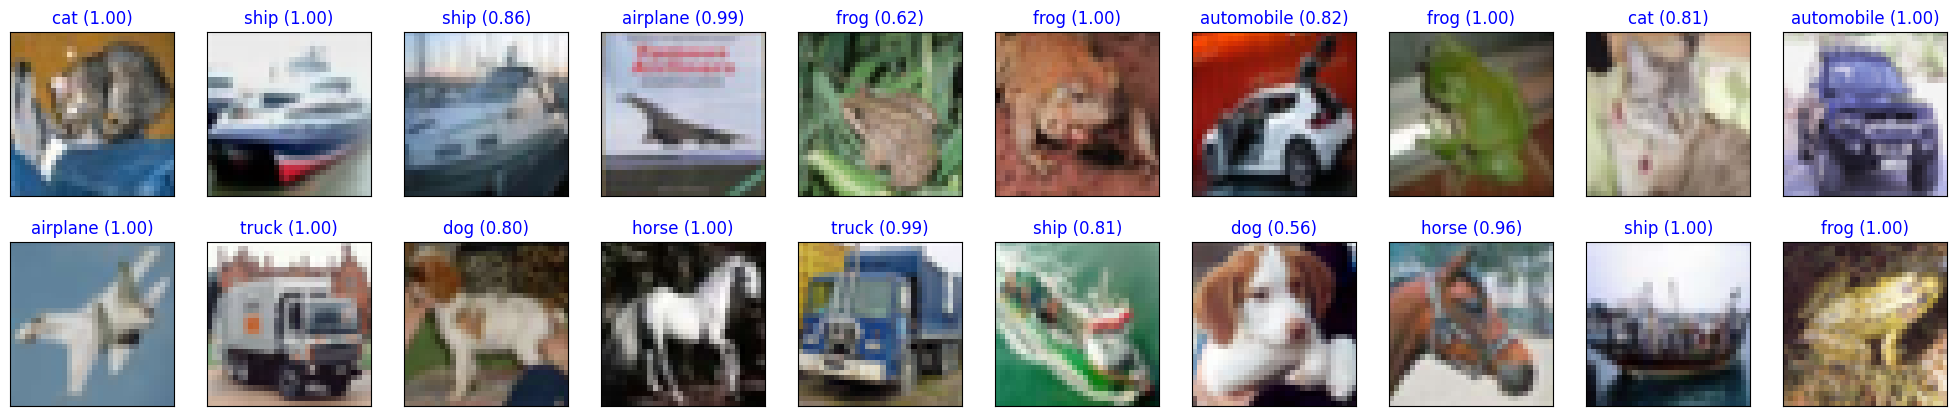

In [10]:
# Show some test images along with predictions
fig = plt.figure(figsize=(25, 5))

for idx in range(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(x_test[idx])
    color = 'blue' if classes[int(y_test[idx])] == classes[int(np.argmax(predictions[idx]))] else 'red'
    plt.title('%s (%.2f)' % (classes[np.argmax(predictions[idx])], predictions[idx].max()), color=color)

<h1><b>Adversarial Robustness<b></h1>

## 1. Adversarial Robustness in the Presence of Fast Gradient Sign Attack (FGSM)

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def fgsm_attack(model, images, labels, epsilon):
    # Convert images to tf.Tensor
    images = tf.convert_to_tensor(images)

    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)

    # Calculate the gradients of the loss with respect to the input images
    gradient = tape.gradient(loss, images)

    # Get the sign of the gradients to create the perturbations
    signed_grad = tf.sign(gradient)

    # Create the adversarial images by adding the perturbations
    adversarial_images = images + epsilon * signed_grad

    # Clip the adversarial images to ensure they are within the valid image range
    adversarial_images = tf.clip_by_value(adversarial_images, 0, 1)

    return adversarial_images

def evaluate_adversarial_accuracy(model, x_test, y_test, epsilon, batch_size=32):
    num_batches = int(np.ceil(len(x_test) / batch_size))
    adv_accuracy = 0

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(x_test))
        x_batch = x_test[start_idx:end_idx]
        y_batch = y_test[start_idx:end_idx]

        adv_images = fgsm_attack(model, x_batch, y_batch, epsilon)
        adv_loss, adv_acc = model.evaluate(adv_images, y_batch, verbose=0)
        adv_accuracy += adv_acc * len(x_batch)

    return adv_accuracy / len(x_test)

Epsilon: 0.000, Adversarial Accuracy: 0.9400
Epsilon: 0.003, Adversarial Accuracy: 0.6000
Epsilon: 0.006, Adversarial Accuracy: 0.4700
Epsilon: 0.009, Adversarial Accuracy: 0.2700
Epsilon: 0.012, Adversarial Accuracy: 0.2300
Epsilon: 0.015, Adversarial Accuracy: 0.1600
Epsilon: 0.018, Adversarial Accuracy: 0.1200
Epsilon: 0.021, Adversarial Accuracy: 0.1100
Epsilon: 0.024, Adversarial Accuracy: 0.1000
Epsilon: 0.027, Adversarial Accuracy: 0.1100
Epsilon: 0.030, Adversarial Accuracy: 0.1100


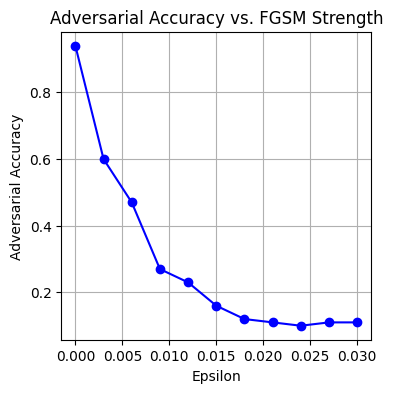

In [12]:
# Define a range of epsilon values to test the strength of FGSM attacks
epsilon_values = np.linspace(0, 0.03, 11)
adversarial_accuracies = []

# Evaluate the model on adversarial examples generated with different epsilon values
for epsilon in epsilon_values:
    adv_accuracy = evaluate_adversarial_accuracy(model, x_test[:100], y_test[:100], epsilon, batch_size=32)
    adversarial_accuracies.append(adv_accuracy)
    print(f'Epsilon: {epsilon:.3f}, Adversarial Accuracy: {adv_accuracy:.4f}')

# Plot the adversarial accuracy as a function of epsilon
plt.figure(figsize=(4, 4))
plt.plot(epsilon_values, adversarial_accuracies, marker='o', linestyle='-', color='b')
plt.title('Adversarial Accuracy vs. FGSM Strength')
plt.xlabel('Epsilon')
plt.ylabel('Adversarial Accuracy')
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 59ms/step


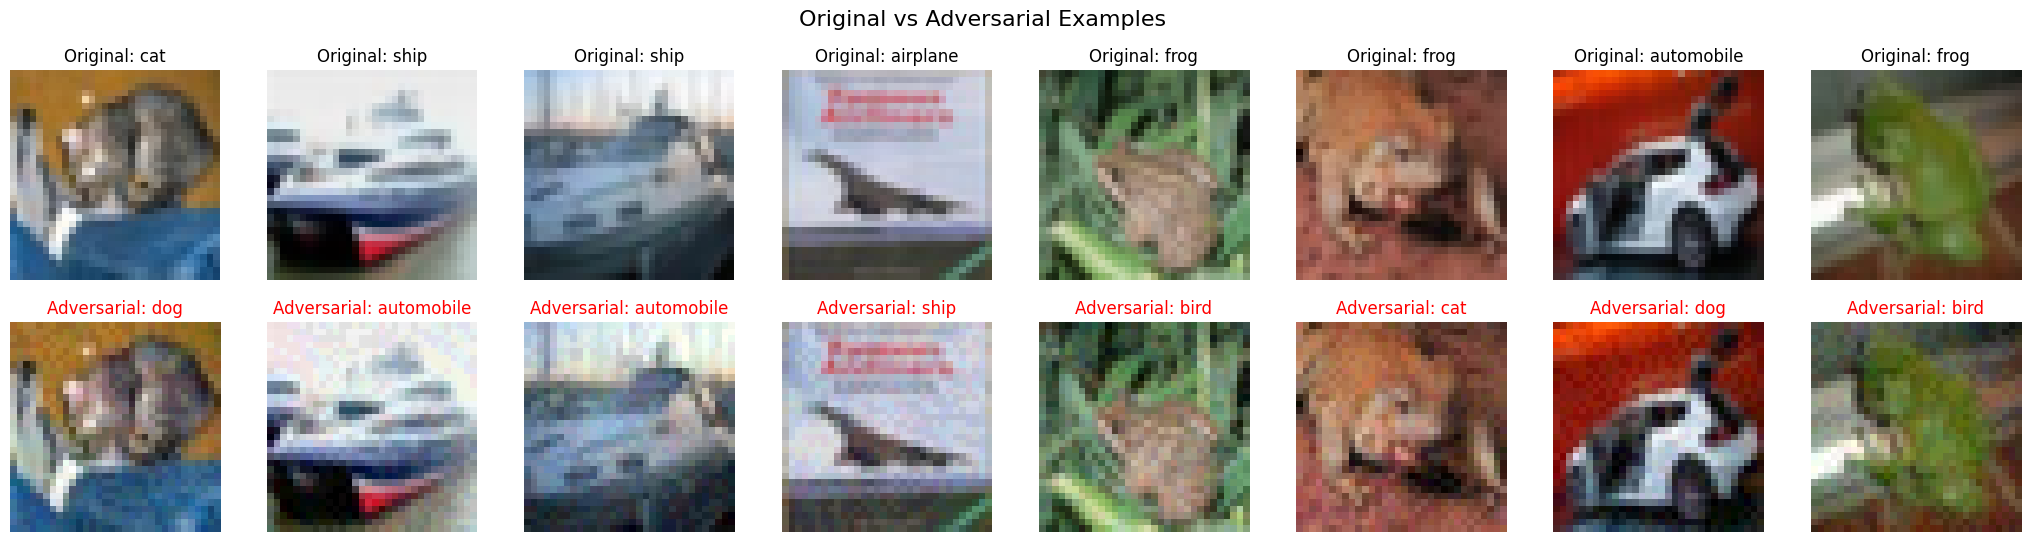

In [13]:
# Select a subset of test images for visualization
num_examples = 8
x_sample = x_test[:num_examples]
y_sample = y_test[:num_examples]

# Define epsilon value for FGSM attack
epsilon = 0.03

# Generate adversarial examples
adv_examples = fgsm_attack(model, x_sample, y_sample, epsilon)

# Plot original and adversarial images
fig, axes = plt.subplots(2, num_examples, figsize=(26, 6))
fig.suptitle('Original vs Adversarial Examples', fontsize=16)

for i in range(num_examples):
    # Original images
    ax = axes[0, i]
    ax.imshow(x_sample[i])
    ax.axis('off')
    ax.set_title(f'Original: {classes[int(y_sample[i])]}')

    # Adversarial images
    ax = axes[1, i]
    ax.imshow(adv_examples[i].numpy())
    ax.axis('off')
    pred_label_idx = np.argmax(model.predict(np.expand_dims(adv_examples[i], axis=0)))
    pred_label = classes[pred_label_idx]
    color = 'red' if pred_label != classes[int(y_sample[i])] else 'blue'
    ax.set_title(f'Adversarial: {pred_label}', color=color)

plt.show()

#2. Projected Gradient Descent Attack and Reconstruction of Adverasarial Examples

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def pgd_attack(model, images, labels, epsilon, alpha, num_iterations):
    # Convert images to tf.Tensor
    images = tf.convert_to_tensor(images)
    original_images = images

    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(images)
            predictions = model(images)
            loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)

        # Calculate the gradients of the loss with respect to the input images
        gradient = tape.gradient(loss, images)

        # Get the sign of the gradients to create the perturbations
        signed_grad = tf.sign(gradient)

        # Create the adversarial images by adding the perturbations
        images = images + alpha * signed_grad

        # Clip the perturbations to ensure they are within the epsilon-ball around the original images
        images = tf.clip_by_value(images, original_images - epsilon, original_images + epsilon)

        # Clip the adversarial images to ensure they are within the valid image range
        images = tf.clip_by_value(images, 0, 1)

    return images

In [15]:
def evaluate_adversarial_accuracy(model, x_test, y_test, epsilon, alpha, num_iterations, batch_size=32):
    num_batches = int(np.ceil(len(x_test) / batch_size))
    adv_accuracy = 0

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(x_test))
        x_batch = x_test[start_idx:end_idx]
        y_batch = y_test[start_idx:end_idx]

        adv_images = pgd_attack(model, x_batch, y_batch, epsilon, alpha, num_iterations)
        adv_loss, adv_acc = model.evaluate(adv_images, y_batch, verbose=0)
        adv_accuracy += adv_acc * len(x_batch)

    return adv_accuracy / len(x_test)

Epsilon: 0.000, Adversarial Accuracy: 0.9400
Epsilon: 0.001, Adversarial Accuracy: 0.8000
Epsilon: 0.002, Adversarial Accuracy: 0.6900
Epsilon: 0.003, Adversarial Accuracy: 0.5700
Epsilon: 0.004, Adversarial Accuracy: 0.5100
Epsilon: 0.005, Adversarial Accuracy: 0.4600
Epsilon: 0.006, Adversarial Accuracy: 0.3600
Epsilon: 0.007, Adversarial Accuracy: 0.2300
Epsilon: 0.008, Adversarial Accuracy: 0.1700
Epsilon: 0.009, Adversarial Accuracy: 0.1100
Epsilon: 0.010, Adversarial Accuracy: 0.0900


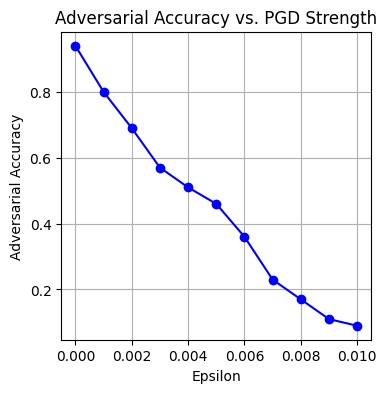

In [16]:
# Parameters for PGD attack
alpha = 0.01
num_iterations = 20

# Define a range of epsilon values to test the strength of PGD attacks
epsilon_values = np.linspace(0, 0.01, 11)
adversarial_accuracies = []

# Evaluate the model on adversarial examples generated with different epsilon values
for epsilon in epsilon_values:
    adv_accuracy = evaluate_adversarial_accuracy(model, x_test[:100], y_test[:100], epsilon, alpha, num_iterations, batch_size=32)
    adversarial_accuracies.append(adv_accuracy)
    print(f'Epsilon: {epsilon:.3f}, Adversarial Accuracy: {adv_accuracy:.4f}')

# Plot the adversarial accuracy as a function of epsilon
plt.figure(figsize=(4, 4))
plt.plot(epsilon_values, adversarial_accuracies, marker='o', linestyle='-', color='b')
plt.title('Adversarial Accuracy vs. PGD Strength')
plt.xlabel('Epsilon')
plt.ylabel('Adversarial Accuracy')
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 37ms/step


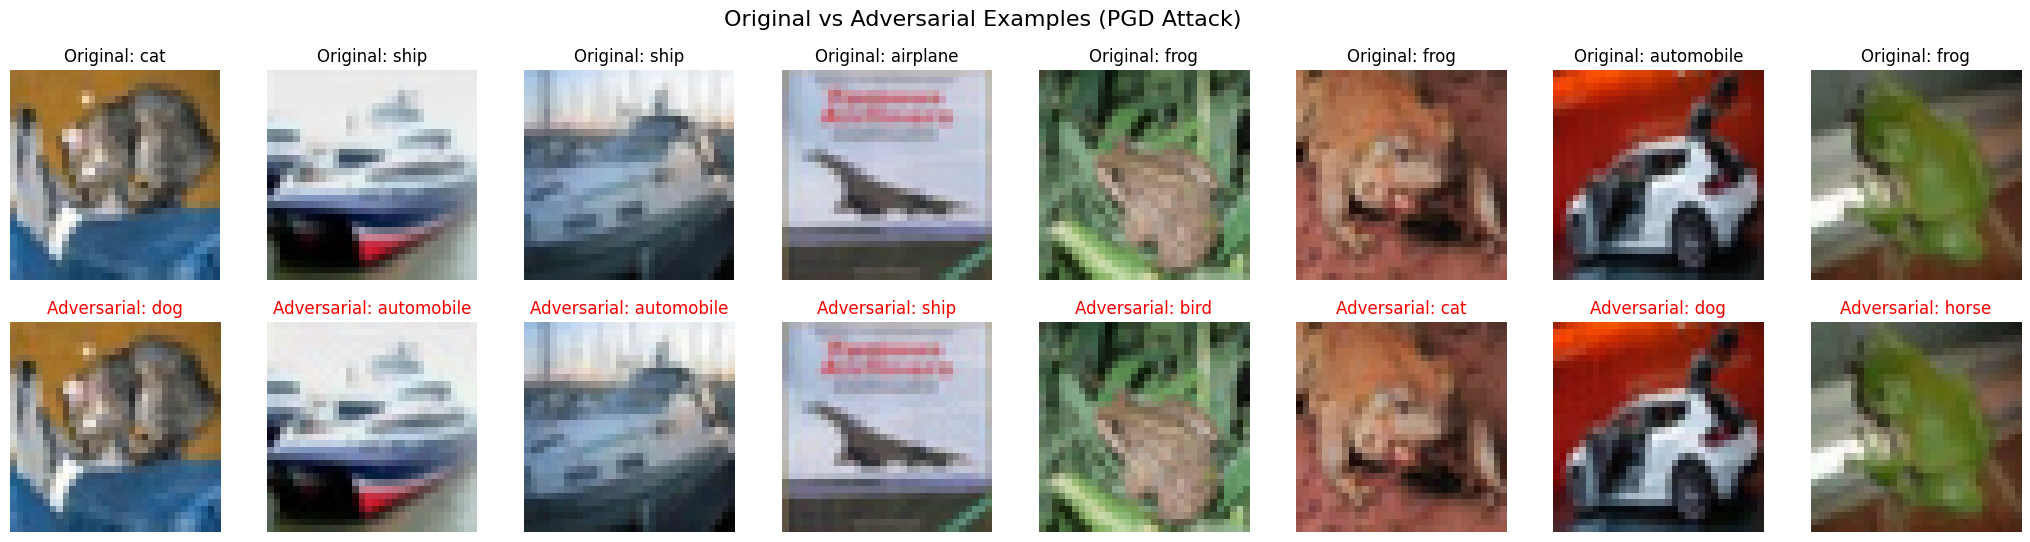

In [17]:
# Parameters for PGD attack
epsilon = 0.01
alpha = 0.01
num_iterations = 20

# Select a subset of test images for visualization
num_examples = 8
x_sample = x_test[:num_examples]
y_sample = y_test[:num_examples]

# Generate adversarial examples using PGD
adv_examples_pgd = pgd_attack(model, x_sample, y_sample, epsilon, alpha, num_iterations)

# Plot original and adversarial images
fig, axes = plt.subplots(2, num_examples, figsize=(26, 6))
fig.suptitle('Original vs Adversarial Examples (PGD Attack)', fontsize=16)

for i in range(num_examples):
    # Original images
    ax = axes[0, i]
    ax.imshow(x_sample[i])
    ax.axis('off')
    ax.set_title(f'Original: {classes[int(y_sample[i])]}')

    # Adversarial images
    ax = axes[1, i]
    ax.imshow(adv_examples_pgd[i].numpy())
    ax.axis('off')
    pred_label_idx = np.argmax(model.predict(np.expand_dims(adv_examples_pgd[i], axis=0)))
    pred_label = classes[pred_label_idx]
    color = 'red' if pred_label != classes[int(y_sample[i])] else 'blue'
    ax.set_title(f'Adversarial: {pred_label}', color=color)

plt.show()

#3. Deep Fool Attack

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def deepfool_attack(model, image, num_classes=10, overshoot=0.02, max_iter=50):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)
    original_image = tf.identity(image)

    f_image = model(image).numpy().flatten()
    I = np.argsort(f_image)[::-1]
    label = I[0]

    pert_image = image
    w = np.zeros(image.shape)
    r_tot = np.zeros(image.shape)

    loop_i = 0
    while loop_i < max_iter:
        with tf.GradientTape() as tape:
            tape.watch(pert_image)
            predictions = model(pert_image)
            loss = predictions[0, label]

        gradients = tape.gradient(loss, pert_image)
        gradients = gradients.numpy()

        pert = np.inf
        for k in range(1, num_classes):
            with tf.GradientTape() as tape:
                tape.watch(pert_image)
                predictions_k = model(pert_image)
                loss_k = predictions_k[0, I[k]]
            gradients_k = tape.gradient(loss_k, pert_image)
            gradients_k = gradients_k.numpy()

            w_k = gradients_k - gradients
            f_k = predictions[0, I[k]] - predictions[0, I[0]]
            pert_k = abs(f_k) / (np.linalg.norm(w_k.flatten()) + 1e-8)  # Added epsilon for numerical stability

            if pert_k < pert:
                pert = pert_k
                w = w_k

        r_i = (pert + 1e-4) * w / (np.linalg.norm(w) + 1e-8)  # Added epsilon for numerical stability
        r_tot = r_tot + r_i

        pert_image = pert_image + (1 + overshoot) * r_i
        pert_image = tf.clip_by_value(pert_image, 0, 1)

        k_i = np.argmax(model(pert_image).numpy().flatten())

        if k_i != label:
            break

        loop_i += 1

    adv_image = pert_image
    return adv_image[0]

def generate_deepfool_adversarial_examples(model, images, max_iter=50, overshoot=0.02):
    adv_images = []
    for idx, image in enumerate(images):
        try:
            adv_image = deepfool_attack(model, image, max_iter=max_iter, overshoot=overshoot)
            adv_images.append(adv_image.numpy())
        except Exception as e:
            print(f"Error generating adversarial example for image {idx}: {e}")
            continue
    return np.array(adv_images)

In [19]:
def evaluate_deepfool_adversarial_accuracy(model, x_test, y_test, batch_size=32, max_iter=20, overshoot=0.02):
    num_batches = int(np.ceil(len(x_test) / batch_size))
    adv_accuracy = 0

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(x_test))
        x_batch = x_test[start_idx:end_idx]
        y_batch = y_test[start_idx:end_idx]

        adv_images = generate_deepfool_adversarial_examples(model, x_batch, max_iter=max_iter, overshoot=overshoot)
        if len(adv_images) == 0:
            print("Warning: No adversarial examples were generated for the current batch.")
            continue
        adv_images = tf.convert_to_tensor(adv_images, dtype=tf.float32)
        adv_loss, adv_acc = model.evaluate(adv_images, y_batch[:len(adv_images)], verbose=0)
        adv_accuracy += adv_acc * len(adv_images)

    return adv_accuracy / len(x_test)

Max Iterations: 0, Adversarial Accuracy: 0.9400
Max Iterations: 1, Adversarial Accuracy: 0.1300
Max Iterations: 2, Adversarial Accuracy: 0.0800
Max Iterations: 3, Adversarial Accuracy: 0.0700


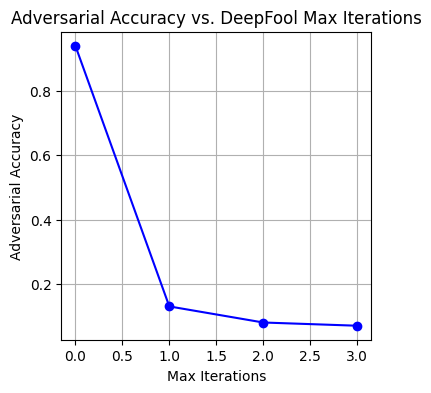

In [20]:
# Select a subset of test images for visualization and attack
num_examples = 100
x_sample = x_test[:num_examples]
y_sample = y_test[:num_examples]

# Define a range of max_iter values to test the strength of DeepFool attacks
max_iter_values = [0, 1, 2, 3]
adversarial_accuracies = []

# Evaluate the model on adversarial examples generated with different max_iter values
for max_iter in max_iter_values:
    adv_accuracy = evaluate_deepfool_adversarial_accuracy(model, x_sample, y_sample, batch_size=32, max_iter=max_iter, overshoot=0.02)
    adversarial_accuracies.append(adv_accuracy)
    print(f'Max Iterations: {max_iter}, Adversarial Accuracy: {adv_accuracy:.4f}')

# Plot the adversarial accuracy as a function of max iterations
plt.figure(figsize=(4, 4))
plt.plot(max_iter_values, adversarial_accuracies, marker='o', linestyle='-', color='b')
plt.title('Adversarial Accuracy vs. DeepFool Max Iterations')
plt.xlabel('Max Iterations')
plt.ylabel('Adversarial Accuracy')
plt.grid(True)
plt.show()

In [ ]:
# Generate adversarial examples using DeepFool
adv_examples_deepfool = generate_deepfool_adversarial_examples(model, x_sample[:8])

if len(adv_examples_deepfool) == 0:
    raise ValueError("No adversarial examples were generated. Please check the DeepFool attack implementation.")

# Plot original and adversarial images for the first 8 examples
fig, axes = plt.subplots(2, 8, figsize=(26, 6))
fig.suptitle('Original vs Adversarial Examples (DeepFool Attack)', fontsize=16)

for i in range(8):
    # Original images
    ax = axes[0, i]
    ax.imshow(x_sample[i])
    ax.axis('off')
    ax.set_title(f'Original: {classes[int(y_sample[i])]}')

    # Adversarial images
    ax = axes[1, i]
    ax.imshow(adv_examples_deepfool[i])
    ax.axis('off')
    pred_label_idx = np.argmax(model.predict(np.expand_dims(adv_examples_deepfool[i], axis=0)))
    pred_label = classes[pred_label_idx]
    color = 'red' if pred_label != classes[int(y_sample[i])] else 'blue'
    ax.set_title(f'Adversarial: {pred_label}', color=color)

plt.show()